# Pauli Channel Experiments

In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import pickle
import json

from qiskit_aer import Aer, AerSimulator
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile

In [2]:
from open_quantum_systems.pauli_channel import *
from open_quantum_systems.math_util import *

### Data Directory

In [3]:
DATA_DIR = './data'

### Backend Configurations:

In [4]:
# Aer simulator configuration:
aer_backend = Aer.get_backend('aer_simulator')
aer_transpile_options = {
    'optimization_level' : 3,
    'approximation_degree' : 0.975
}

# IonQ configuration:
ionq_transpile_options = {
    'optimization_level' : 3,
    'approximation_degree' : 0.975
}

# IonQ Simulator configuration:
ionq_simulator_options = {
    "error-mitigation": {
        "debias": True
    },
        "noise": {
        "model": "harmony",
        "seed": 1000
    }
}

# IonQ QPU configuration:
ionq_real_qpu_options = {
    "error-mitigation": {
        "debias": True
    }
}

def save_data(job_data, filename):
    with open(os.path.join(DATA_DIR, filename), 'wb') as f:
        pickle.dump(job_data, f)

def load_data(filename):
    with open(os.path.join(DATA_DIR, filename), 'rb') as f:
        return pickle.load(f)

def save_json_data(job_array, filename):
    with open(os.path.join(DATA_DIR, filename), 'w') as f:
        f.write(json.dumps(job_array))

## 📝 **Configure Job Submission Here** 📝

To submit jobs on real quantum hardware, you will need to configure the following variables:

1. **`quantum_backend`**: Qiskit backend that will be targeted for transpilation. If the provider has a Qiskit backend, set this variable to the correct backend.
2. **`quantum_transpile_options`**: Options for the Qiskit transpiler. I would recommend the following options:
  * `{'optimization_level' : 3, 'approximation_degree' : 0.975 }`

In addition, you will also need to define the following functions:

3. **`launch_quantum_job(circuits, shots)`**:
    * This function submits a list of circuits to the provider, running each circuit with the given number of shots. The function must return a list of unique job identifiers (`job_array`), which can be saved and later used to retrieve the jobs from the provider. Currently this function returns an Aer job object to simulate submission to a server. You will need to change this to instead return a list of unique job ids for each submitted circuit (IDs in string format are preferred).

4. **`get_quantum_job_results(circuits, shots)`**:
    * This function retrieves the results corresponding to a list of unique job identifiers (i.e. the same `job_array` list that was returned from `launch_quantum_job`). The function must return a list of measurement count dictionaries corresponding to each unique id in `job_array`. For example, these dictionaries take the form: `{'00': 721, '01': 1327}`. This dictionary can easily be retrieved from a qiskit job object using the `result.get_counts()` function.
          

In [5]:

# 1. This is the backend that is targeted by Qiskit's transpiler/optimizer
quantum_backend = aer_backend

# 2. These are the transpiler options:
quantum_transpile_options = aer_transpile_options

# 3. This function submits a list of circuits and submits them to the provider and
#    returns a list of unique job ids.
def launch_quantum_job(circuits, shots):
    job_array = [
        quantum_backend.run(c, shots=shots) for c in circuits
    ]
    
    return job_array # <-- This should be a list of unique job ids (preferably strings)

# 4. This function retrieves the results jobs from the provider based on a list of job ids.
def get_quantum_job_results(job_array):

    result_counts = [
        job.result().get_counts()
        for job in job_array
    ]
    
    return result_counts # <-- This should be a list of measurement count dictionaries

quantum_primitive_kwargs = {
    'launch_job_fn' : launch_quantum_job,
    'get_result_fn' : get_quantum_job_results
}

### Experiment Parameters:

In [6]:
pauli_strings = ['IX', 'XI', 'ZZ', 'XX']
gammas = [0.1, 0.1, 1.0, 1.0]

initial_state = np.array([0,0,-3/5,-4/5],dtype=np.complex128)
n_trajectory_samples = 19
t_range = (0,2)

n_qubits = 2
kraus_order = 2
shots = 2048

In [7]:
sim = PauliChannelSimulation(n_qubits=n_qubits, 
                             pauli_strings=pauli_strings, 
                             gammas=gammas, 
                             kraus_order=kraus_order)

## Experiment 1: 
Simulating Partial density trajectory of a Pauli Channel

In [8]:
t_vals = np.linspace(*t_range, 1000)
sample_t_vals = np.linspace(*t_range,n_trajectory_samples)

ideal_probs = sim.simulate_pure_state_evolution(
    pure_state=initial_state,
    t=t_vals, 
    backend=aer_backend,
    shots=shots,
    renormalize=True)

classical_densities = sim.simulate_classical_density_matrix_evolution(
    initial_state=initial_state,
        t=t_vals)

classical_probs = np.array([ np.abs(np.diag(rho)) for rho in classical_densities ])

### 1. Submit Jobs:

In [9]:
# noisy_probs_job = sim.simulate_pure_state_evolution(
#                     pure_state=initial_state,
#                     t=t_vals,
#                     backend=quantum_backend,
#                     shots=shots,
#                     transpile_options=quantum_transpile_options,
#                     primitive_kwargs=quantum_primitive_kwargs | dict(submit_jobs_only=True))

In [10]:
# stinespring_noisy_probs_job = sim.simulate_stinespring_pure_state_evolution(
#         pure_state=initial_state,
#         t=sample_t_vals,
#         backend=quantum_backend,
#         shots=shots,
#         transpile_options=quantum_transpile_options,
#         primitive_kwargs=quantum_primitive_kwargs | dict(submit_jobs_only=True)
# )

**Note**: The following cell will fail to run if you are using the Aer-based `launch_job` function, but you should still be able to run the rest of the notebook. If you have properly defined the `launch_job` function it will save the ids of submitted jobs so you can load them later on.

In [11]:
#save_data(noisy_probs_job, 'pc_job.pkl')
#save_data(stinespring_noisy_probs_job, 'pc_s_job.pkl')

### 2. Retrieve Job Results:

In [12]:
#noisy_probs_job = load_data('pc_job.pkl')
#stinespring_noisy_probs_job = load_data('pc_s_job.pkl')

In [13]:
# noisy_probs = sim.simulate_pure_state_evolution(
#                     pure_state=initial_state,
#                     t=t_vals,
#                     backend=quantum_backend,
#                     shots=shots,
#                     transpile_options=quantum_transpile_options,
#                     primitive_kwargs=quantum_primitive_kwargs | dict(submitted_jobs_data=noisy_probs_job))

In [14]:
# stinespring_noisy_probs = sim.simulate_stinespring_pure_state_evolution(
#         pure_state=initial_state,
#         t=sample_t_vals,
#         backend=quantum_backend,
#         shots=shots,
#         transpile_options=quantum_transpile_options,
#         primitive_kwargs=quantum_primitive_kwargs | dict(submitted_jobs_data=stinespring_noisy_probs_job)
# )

In [15]:
# save_data(stinespring_noisy_probs, 'pc_s_data.pkl')
# save_data(noisy_probs, 'pc_data.pkl')

In [16]:
stinespring_noisy_probs = load_data('pc_s_data_h1.pkl')
noisy_probs = load_data('pc_data_h1.pkl')

In [17]:
# re-order qubit indices (due to PyTket's conventions):
reorder_idx = np.array([0,2,1,3])
stinespring_noisy_probs = np.take(stinespring_noisy_probs, reorder_idx, axis=-1)
noisy_probs = np.take(noisy_probs, reorder_idx, axis=-1)

### 3. Visualize Results;

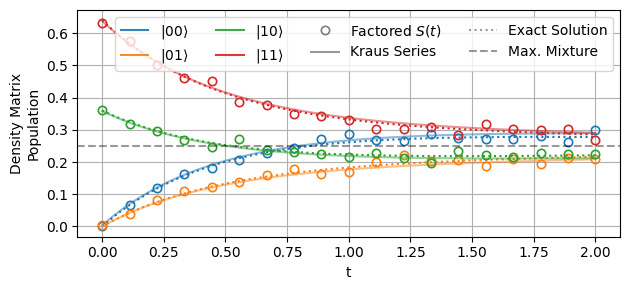

In [18]:
import matplotlib.pyplot as plt
cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ket_names = [r'$|00\rangle$', r'$|01\rangle$', r'$|10\rangle$', r'$|11\rangle$']

plt.figure(figsize=(6.4,3))
for noisy_ket, stinespring_ket, classical_ket, ket_name in \
    zip(noisy_probs.T, stinespring_noisy_probs.T, classical_probs.T, ket_names):
    color = next(cycle)
    plt.plot(t_vals, classical_ket, ':', color=color)
    plt.plot(t_vals, noisy_ket, color=color, alpha=0.5)
    plt.plot(sample_t_vals, stinespring_ket, 'o', fillstyle='none', markeredgewidth=1.2, color=color)
    plt.plot([], [], color=color, label=ket_name, alpha=0.9)

plt.plot([],[],'o', fillstyle='none', color='k', alpha=0.5, markeredgewidth=1.2, label='Factored $S(t)$')
plt.plot([],[], color='k', alpha=0.4, label='Kraus Series')
plt.plot([], [], ':', color='k', alpha=0.4, label='Exact Solution')

plt.axhline(2**(-sim.n_qubits), linestyle='--', color='k', alpha=0.4, label='Max. Mixture')
plt.ylabel('Density Matrix\nPopulation')
plt.xlabel('t')
plt.grid()
plt.legend(ncol=4)
plt.tight_layout()
plt.show()

In [19]:
IZ = make_pauli_operator('IZ')
ZI = make_pauli_operator('ZI')
ZZ = make_pauli_operator('ZZ')

diag_observables = [ IZ, ZI, ZZ ]
diag_observables_names = [
    r'$\langle IZ \rangle$',
    r'$\langle ZI \rangle$',
    r'$\langle ZZ \rangle$'
]

classical_evals = [
    [ np.trace(obs @ np.diag(p)) for p in classical_probs ]
    for obs in diag_observables
]
stinespring_noisy_evals = [
    [ np.trace(obs @ np.diag(p)) for p in stinespring_noisy_probs ]
    for obs in diag_observables
]
noisy_evals = [
    [ np.trace(obs @ np.diag(p)) for p in noisy_probs ]
    for obs in diag_observables
]

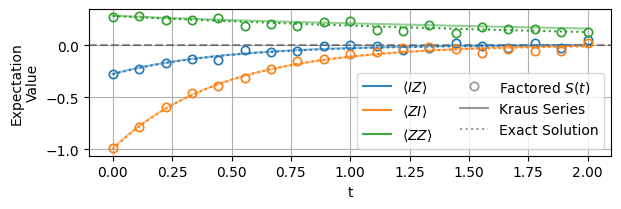

In [20]:
plt.figure(figsize=(6.4,2.2))
cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.axhline(0, linestyle='--', color='k', alpha=0.4)

for name, classical_eval, quantum_eval, stinespring_eval in zip(
    diag_observables_names, 
    classical_evals, 
    noisy_evals,
    stinespring_noisy_evals):
    
    color= next(cycle)
    plt.plot(t_vals, classical_eval, linestyle=':', color=color)
    plt.plot(sample_t_vals, stinespring_eval, 'o', color=color, fillstyle='none', markeredgewidth=1.2)
    plt.plot(t_vals, quantum_eval, color=color, alpha=0.5)
    plt.plot([], [], color=color, alpha=0.9, label=name)

plt.plot([],[],'o', fillstyle='none', markeredgewidth=1.2, color='k', alpha=0.4, label='Factored $S(t)$')
plt.plot([],[], color='k', alpha=0.4, label='Kraus Series')
plt.plot([], [], ':', color='k', alpha=0.4, label='Exact Solution')
plt.ylabel('Expectation\nValue')
plt.xlabel('t')
plt.grid()
plt.legend(ncol=2)
plt.tight_layout()
plt.show()